Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path

# Plotting
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('../bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from stats import *
from plotting_functions import *
from synthetic_grid_cells import *
from methods import multiimshow

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
boxsize = experiment.environments[0].boxsize

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


### Coherent grid orientation modules

In [4]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices.npz")
print(module_indices.files)
module_indices = module_indices['C5_from_env_2']

['C0_from_env_0', 'C1_from_env_1', 'C5_from_env_2']


In [5]:
cell_selection_name = 'gardner'
if cell_selection_name == 'gcs':
    gs_masks = grid_score_masks(experiment, percentile=0.55, mode="intersection")
elif cell_selection_name == 'gardner':
    gs_masks = np.zeros(4096,dtype=bool)
    gs_masks[module_indices] = 1
ratemaps = get_smooth_ratemaps(experiment, sigma=1.0)
num_cells_included = np.sum(gs_masks)
print("Num cells included: ", num_cells_included)

Num cells included:  315


In [6]:
calculated_orientations = apply_scalarFn_to_selection(grid_orientation, ratemaps, gs_masks)

In [7]:
panesize = set_size(width=345, mode='max')
panesize

figsize=(panesize[0]/3,panesize[1]/6)
figsize=np.array(figsize)

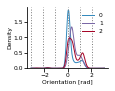

In [8]:
# von Mises KDE parameter
kappa = 50.0
thetas = np.linspace(-np.pi, +np.pi, num=1001)

fig, ax = plt.subplots(figsize=figsize)
for env_i, orientations_env in enumerate(calculated_orientations):
    # Kernel density estimation with periodic gaussian kernel (von Mises kernel)
    # because orientation is 2-pi periodic
    von_mises_pdf = circular_kernel(orientations_env, kappa=kappa)
    ax.plot(thetas, von_mises_pdf(thetas), label=f'{env_i}')
ymin, ymax = ax.get_ylim()
ax.set_ylim((ymin, ymax))
ax.vlines(
    np.array(
        [((60.0*i)*np.pi / 180.0) - np.pi for i in range(6)]
    ),
    ymin=ymin,
    ymax=ymax,
    color='grey',
    linestyles=':'
)
ax.set_ylim(bottom=0)
ax.set_ylabel(r"Density")
ax.set_xlabel(r"Orientation [rad]")
ax.legend()

fig.savefig(experiment.paths['experiment'] / f'plots/experimental-orientations-{cell_selection_name}')

In [9]:
experiment.paths['experiment']

PosixPath('/mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME')

### Orientation Shifts

In [10]:
calculated_orientations_with_nans = apply_scalarFn_to_selection(grid_orientation, ratemaps, gs_masks, rm_nan=False)
calculated_orientation_shifts = scalar_shifts(calculated_orientations_with_nans)

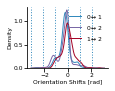

In [11]:
# von Mises KDE parameter
kappa = 50.0
thetas = np.linspace(-np.pi, +np.pi, num=1001)
no_envs = len(calculated_orientation_shifts)

fig, ax = plt.subplots(figsize=figsize)

# iterate over upper triangular in environment indices
for env_i in range(no_envs):
    for env_j in range(env_i + 1, no_envs):
        
        # remove nans from shift array
        or_shifts = calculated_orientation_shifts[env_i, env_j]
        or_shifts = or_shifts[~np.isnan(or_shifts)]
    
        # Kernel density estimation with periodic gaussian kernel (von Mises kernel)
        # because orientation is 2-pi periodic
        von_mises_pdf = circular_kernel(or_shifts, kappa=kappa)
        pdf_vals = von_mises_pdf(thetas)
        
        ax_idx = env_i + env_j - 1
        ax.plot(thetas, pdf_vals, label=r"$" + str(env_i) + " \leftrightarrow " + str(env_j) + "$")

ymin, ymax = ax.get_ylim()
ax.set_ylim((ymin, ymax))
ax.vlines(
    np.array(
        [((60.0*i)*np.pi / 180.0) - np.pi for i in range(6)]
    ),
    ymin=ymin,
    ymax=ymax,
    linestyles=':'
)
ax.set_ylim(bottom=0)
ax.set_ylabel(r"Density")
ax.set_xlabel(r"Orientation Shifts [rad]")
ax.legend()
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-orientation-shifts-{cell_selection_name}')

### Spacings

In [12]:
# dimensionalize grid_spacing function
dim_grid_spacing = lambda ratemap: grid_spacing(ratemap, boxsize=boxsize)

spacings_list = apply_scalarFn_to_selection(dim_grid_spacing, ratemaps, gs_masks)

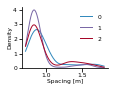

In [13]:
# kde parameter
bw_method = 0.3
epsilon = 0.02 # extend x-lim with epsilon (since kde
experimental_xlims = (0.7165115232238575, 1.8037516887617548)

fig, ax = plt.subplots(figsize=figsize)
for env_i, spacings_env in enumerate(spacings_list):
    # Kernel density estimation
    spacing_pdf = gaussian_kde(spacings_env, bw_method=bw_method)
    #spacings = np.linspace(np.amin(spacings_env)-epsilon, np.amax(spacings_env)+epsilon, num=1001)
    spacings = np.linspace(*experimental_xlims, num=1001)
    ax.plot(spacings, spacing_pdf(spacings),label=r"$" + str(env_i) + "$")
    
ax.set_ylim(bottom=0)
ax.set_ylabel(r"Density")
ax.set_xlabel(r"Spacing [m]")
ax.legend()
#fig.savefig(experiment.paths['experiment'] / f'plots/spacings')
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-spacings-{cell_selection_name}')

### Spacing Shifts

In [14]:
spacings_list = apply_scalarFn_to_selection(dim_grid_spacing, ratemaps, gs_masks, rm_nan=False)
spacings_shifts = scalar_shifts(spacings_list)

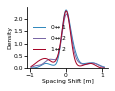

In [15]:
# parameter
res = 1001
# kde
bw_method = 0.3

no_envs = len(spacings_list)
max_shift,min_shift = (1.0632180317716684, -0.9609212606138653) # experimental xlims
#max_shift = np.nanmax(spacings_shifts)
#min_shift = np.nanmin(spacings_shifts)
spacings = np.linspace(min_shift, max_shift, num=res)

fig, ax = plt.subplots(figsize=figsize)

# iterate over upper triangular (shift statistics)
for env_i in range(no_envs):
    for env_j in range(env_i + 1, no_envs):
        
        # remove nan values
        sp_shifts = spacings_shifts[env_i, env_j]
        sp_shifts = sp_shifts[~np.isnan(sp_shifts)]
        
        # Kernel density estimation
        noise = np.random.normal(0,0.001,size=sp_shifts.shape)
        pdf = gaussian_kde(sp_shifts+noise, bw_method=bw_method)
        pdf_vals = pdf(spacings)
        
        ax_idx = env_i + env_j - 1
        ax.plot(spacings, pdf_vals,label=r"$" + str(env_i) + " \leftrightarrow " + str(env_j) + "$",)
        #ax.hist(sp_shifts,bins=50)

ax.set_ylim(bottom=0)
ax.set_ylabel(r"Density")
ax.set_xlabel(r"Spacing Shift [m]")
ax.legend()
#fig.savefig(experiment.paths['experiment'] / f'plots/spacing-shifts')
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-spacing-shifts-{cell_selection_name}')

### Phase Shifts

In [16]:
calculated_phases = []
for env_i in range(3): # num environments
    calculated_phases.append([phase_fn(ratemaps[env_i,gs_masks][i],boxsize) for i in range(num_cells_included)])
calculated_phases = np.array(calculated_phases)

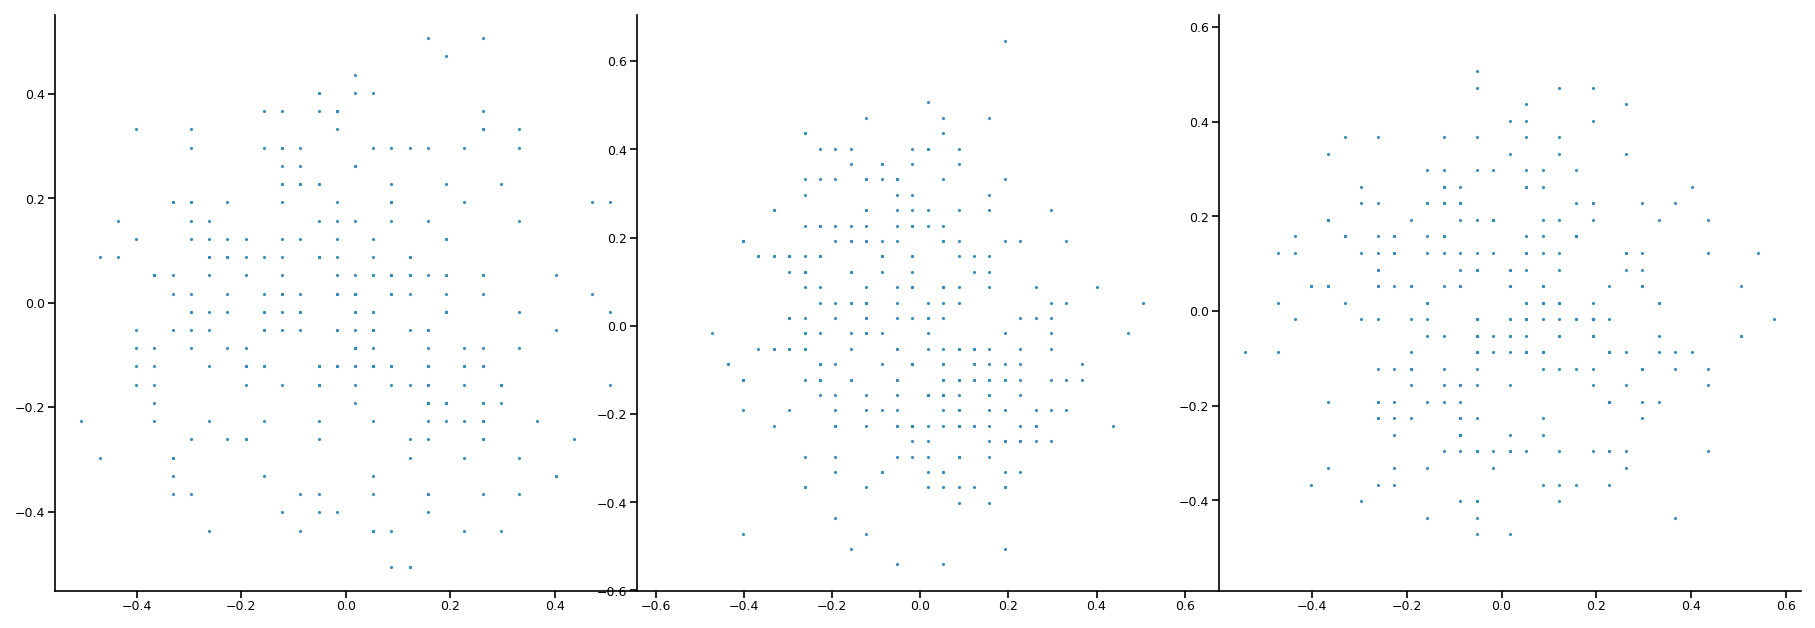

In [28]:
fig,axs = plt.subplots(ncols=3,figsize=(12,4))
[axs[i].scatter(*calculated_phases[i].T) for i in range(3)]# not swapping x and y - but distributing arguments.
_=[axs[i].axis('equal') for i in range(3)]

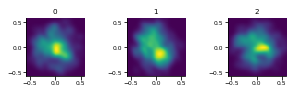

In [18]:
# parameter
res = 64
# kde
bw_method = 0.3

figsize=(panesize[0],panesize[1]/6)
fig, axs = plt.subplots(ncols=3,figsize=figsize)
max_val = np.nanmax(calculated_phases)
labels = [r"$0$", r"$1$", r"$2$"]

for env_i in range(no_envs):
    tmp_phases = calculated_phases[env_i] # in cardinal coordinates
    tmp_phases[...,1] = - tmp_phases[...,1]
    tmp_phases = tmp_phases[...,::-1]
    heatmap = kde_heatmap(tmp_phases,max_val,res,bw_method)
    axs[env_i].imshow(heatmap.T,extent=[-max_val, max_val, -max_val, max_val],origin='lower')
    axs[env_i].set_title(labels[env_i])
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-phases-{cell_selection_name}')

In [19]:
calculated_orientations_with_nans = np.array(calculated_orientations_with_nans)
calculated_phase_shifts = phase_shift_fn(calculated_phases,calculated_orientations_with_nans)
calculated_phase_shifts = [cps[~np.prod(np.isnan(cps),axis=-1,dtype=bool)] for cps in calculated_phase_shifts]

In [20]:
[cps.shape for cps in calculated_phase_shifts]

[(315, 2), (315, 2), (315, 2)]

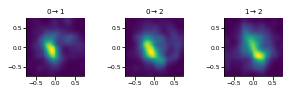

In [21]:
res = 64
bw_method = 0.3

fig, axs = plt.subplots(ncols=3,figsize=figsize)
max_val = 0.74 #np.nanmax(calculated_phase_shifts[0])
labels = [r"$0 \rightarrow 1$", r"$0 \rightarrow 2$", r"$1 \rightarrow 2$"]

for env_i in range(no_envs):
    noise = np.random.normal(0,0.001,size=calculated_phase_shifts[env_i].shape)
    heatmap = kde_heatmap(calculated_phase_shifts[env_i]+noise,max_val,res,bw_method)
    axs[env_i].imshow(heatmap,extent=[-max_val, max_val, -max_val, max_val])
    #axs[env_i].scatter(*calculated_phase_shifts[env_i].T)
    axs[env_i].set_title(labels[env_i])
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-phase-shifts-{cell_selection_name}')

In [22]:
np.argmax(heatmap)

2661

#### Magnitude distribution

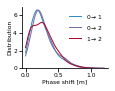

In [23]:
# parameter
res = 1001
# kde
bw_method = 0.3

max_val = np.nanmax([np.nanmax(cps) for cps in calculated_phase_shifts])#np.nanmax(calculated_phase_shifts)
max_magnitude = np.sqrt(2)*max_val
#magnitudes = np.linspace(0.0, max_magnitude, num=res)
magnitudes = np.linspace(0.0, 1.2, num=res)

figsize=(panesize[0]/3,panesize[1]/6)
fig, ax = plt.subplots(figsize=figsize)

# iterate over upper triangular (shift statistics)
for env_i in range(no_envs):
        
    ps = calculated_phase_shifts[env_i]
    # remove nans from statistics
    #ps = ps[~np.isnan(ps).any(axis=1)]
    ps_magnitude = np.linalg.norm(ps,axis=-1)

    noise = np.random.normal(0,0.001,size=ps_magnitude.shape)
    pdf = gaussian_kde(ps_magnitude+noise, bw_method=bw_method)
    pdf_vals = pdf(magnitudes) / (magnitudes + bw_method/2)

    ax.plot(magnitudes,pdf_vals,label=labels[env_i])

ax.set_ylim(bottom=0.)
ax.set_ylabel(r"Distribution")
ax.set_xlabel("Phase shift [m]")
ax.legend()
#fig.savefig(experiment.paths['experiment'] / f'plots/magnitude-shifts')
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-magnitude-shifts-{cell_selection_name}')

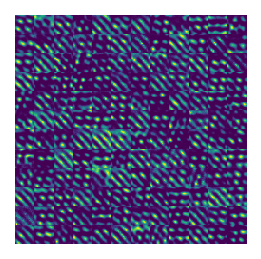

In [24]:
from methods import multiimshow
plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.subplot.wspace"] = 0
plt.rcParams["figure.subplot.hspace"] = 0
plt.rcParams["figure.subplot.left"] = 0.02
plt.rcParams["figure.subplot.right"] = 0.99
plt.rcParams["figure.subplot.bottom"] = 0.02
plt.rcParams["figure.subplot.top"] = 0.98
#plt.rcParams["figure.autolayout"] = True

figsize=(panesize[0]/3,panesize[1]*2/6)
figsize=(min(figsize), min(figsize)) # make square

env_i = 0
fig, axs = multiimshow(ratemaps[env_i,gs_masks][:144],figsize=np.array(figsize))#,figsize_i=0.3)
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-ratemaps-{cell_selection_name}-{env_i}')

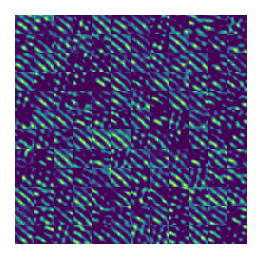

In [25]:
env_i = 1
fig, axs = multiimshow(ratemaps[env_i,gs_masks][:144],figsize=np.array(figsize))#,figsize_i=0.3)
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-ratemaps-{cell_selection_name}-{env_i}')

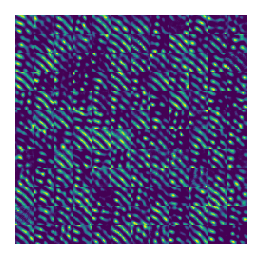

In [26]:
env_i = 2
fig, axs = multiimshow(ratemaps[env_i,gs_masks][:144],figsize=np.array(figsize))#,figsize_i=0.3)
fig.savefig(experiment.paths['experiment'] / f'plots/experimental-ratemaps-{cell_selection_name}-{env_i}')

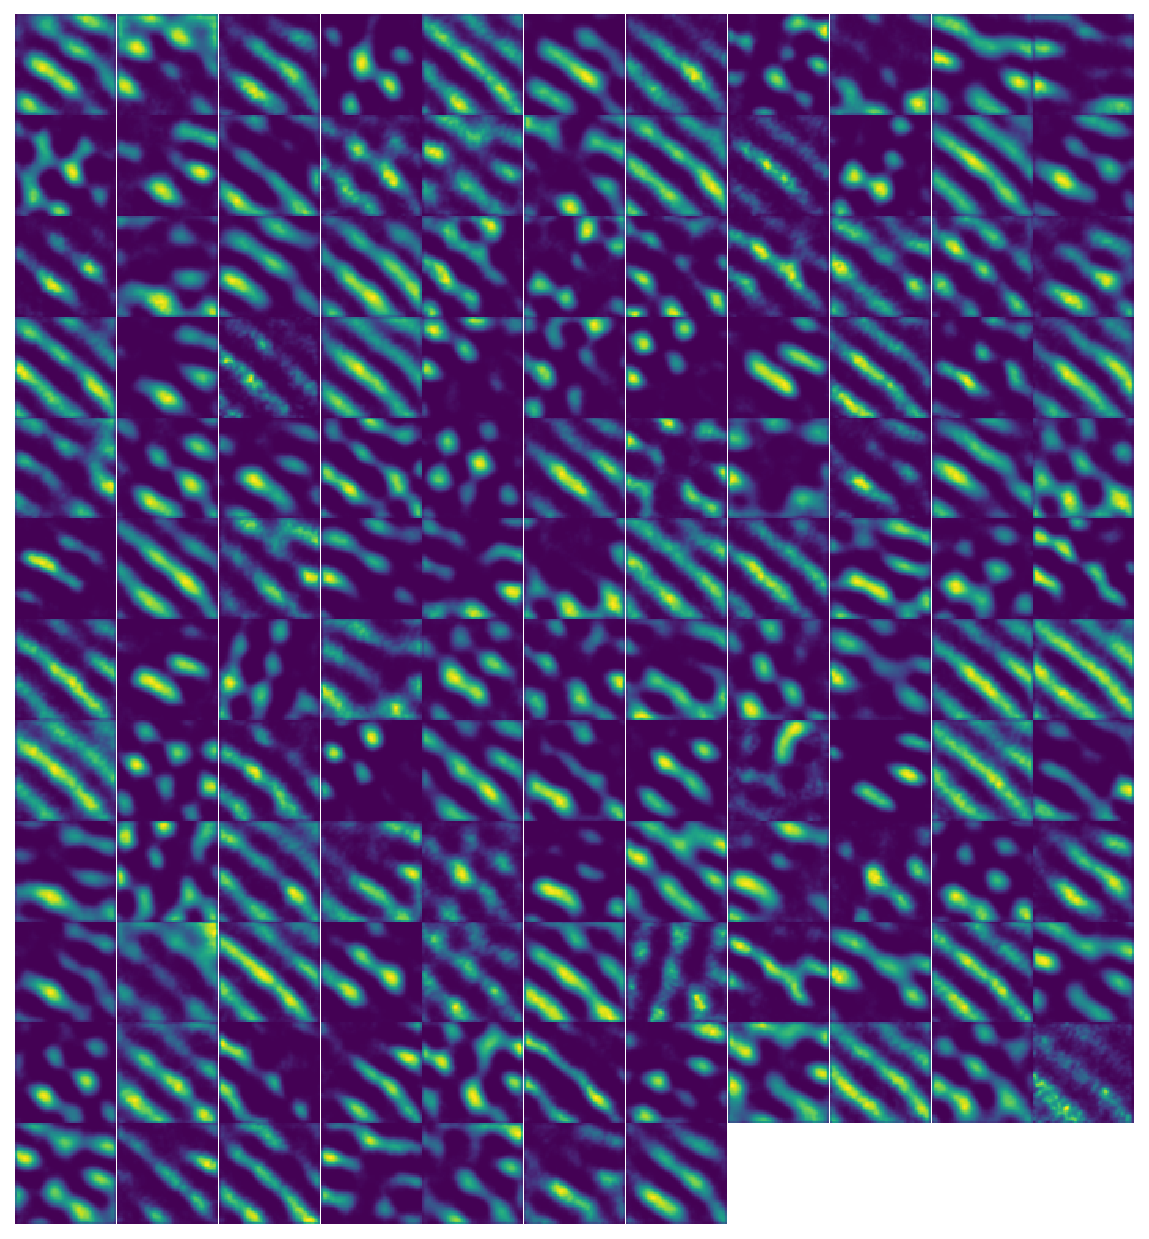

In [27]:
from methods import multiimshow
env_i = 1
fig, axs = multiimshow(ratemaps[env_i,gs_masks][:128])